In [1]:
import csv
import json
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import random
from collections import deque
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import load_model

In [2]:
#NEW DATA TEST
caiso=pd.read_csv("/Users/john_schafer/Downloads/CE291/CAISO_zone_1_.csv")

#Transform Data to our format
caiso['time'] = pd.to_datetime(caiso['time'])
caiso.set_index('time', inplace=True)

# Function to reshape the data
def reshape_data(df, column):
    # Resample data to daily frequency, and apply list to convert each day's data into a list
    daily_data = df[column].resample('D').apply(list)
    # Convert lists to a DataFrame, which inherently transposes the list to columns
    return pd.DataFrame(daily_data.tolist(), index=daily_data.index)

# Creating each DataFrame
demand_df = reshape_data(caiso, 'load_power')
solar_df = reshape_data(caiso, 'solar_power')
wind_df = reshape_data(caiso, 'wind_power')

def rename_columns(df):
    num_minutes = df.shape[1]
    time_labels = [str(pd.Timedelta(minutes=i)) for i in range(num_minutes)]
    df.columns = time_labels
    return df

demand_df = rename_columns(demand_df)
solar_df = rename_columns(solar_df)
wind_df = rename_columns(wind_df)


#Scaling 
# if power is normalized to 1, PEV dynamics in environment are run in kw
#max power of single Ev = 11 kw 
#max power of representative small microgrid of 5,000 people ~ 3.5 megawatts=3,500 kw
#multiply vby 3500 to get representative 
demand_caiso = np.array(demand_df)
solar_caiso = np.array(solar_df)*5 
wind_caiso = np.array(wind_df)*4 
net_caiso=demand_caiso-solar_caiso-wind_caiso

average_demand_per_minute = np.nanmean(demand_caiso, axis=0)
average_solar_per_minute = np.nanmean(solar_caiso, axis=0)
average_wind_per_minute = np.nanmean(wind_caiso, axis=0)

average_net_per_minute=average_demand_per_minute-average_solar_per_minute-average_wind_per_minute

#Sample only every ten minutes
average_demand_10min= average_demand_per_minute[::10]
average_solar_10min= average_solar_per_minute[::10]
average_wind_10min= average_wind_per_minute[::10]

average_net_10min=average_demand_10min-average_solar_10min-average_wind_10min

average_demand_10min= average_demand_10min.reshape(144,1).T
average_solar_10min=average_solar_10min.reshape(144,1).T
average_wind_10min=average_wind_10min.reshape(144,1).T

In [3]:
from DQL_FFNN import DQNAgent
from env_FFNN import GridEnvironment
import time
from tensorflow.keras.models import load_model

In [4]:

timestep_length=(10/60) #in hours
N=800

day_index=0
#model_500 = tf.keras.models.load_model('/Users/john_schafer/Downloads/CE291/CE291-V2G/model_perc_action_500.h5')
# Initialize DQN agent
agent = DQNAgent(state_size=3, action_size=21)

episode_durations = []

for episode in range(1):  # Loop over 3 episodes of same "average" day
    # Initialize environment for the current day
    start_time = time.time()
    env = GridEnvironment(N, average_demand_10min, average_solar_10min, average_wind_10min, day_index, timestep_length)
    
    total_reward = 0
    T = 144  # Assume T timesteps in a day

    demand_profile = np.zeros(T)
    solar_profile = np.zeros(T)
    wind_profile = np.zeros(T)
    PEV_profile = np.zeros(T)

    for timestep in range(1, T+1):  # Loop through each timestep in the day
        normalized_timestep = np.array([timestep / T])   # T is the total number of timesteps in a day

        current_demand, current_solar, current_wind, current_SoC = env.get_state()
        current_P_EV= env.P_EV

        current_state=np.concatenate([np.array([current_demand, current_solar, current_wind])])

        #print("timestep", timestep)
        action_index = agent.act(current_state)  # Decide action based on current state

        # Execute action in the environment and observe the next state, reward, and done flag
        reward, done, next_demand, next_solar, next_wind, next_P_EV, next_SoC = env.step(action_index)

        # Update profiles for plotting
        demand_profile[timestep - 1] = current_demand
        solar_profile[timestep - 1] = current_solar
        wind_profile[timestep - 1] = current_wind
        PEV_profile[timestep - 1] = np.sum(next_P_EV)
        
    
        # Construct the new state from the separated components
        next_state = np.concatenate([np.array([next_demand, next_solar, next_wind])])

        # Directly learn from this transition without using replay
        agent.learn(current_state, action_index, reward, next_state, done)

        # Update state and total_reward
        #state = next_state why did I have this?
        total_reward += reward

        if done:
            # Handle episode completion, if applicable
            break
    #agent.epsilon=max(agent.epsilon_min, agent.epsilon * agent.epsilon_decay) 

    print(f"Total reward for episode {episode}: {total_reward}")
    episode_durations.append(time.time() - start_time)
#agent.model.save('model_FFNN_250.h5')
print("Individual episode durations:", episode_durations)

timestep 1
action test -0.5
numevs test 400
selected evs tes [47, 318, 399, 288, 181, 551, 459, 218, 631, 289, 458, 461, 37, 230, 226, 368, 144, 539, 445, 261, 366, 324, 423, 543, 733, 678, 530, 609, 546, 53, 52, 129, 467, 205, 353, 684, 498, 734, 36, 400, 190, 40, 29, 79, 298, 510, 405, 246, 313, 41, 548, 396, 661, 350, 90, 668, 667, 113, 381, 330, 433, 561, 355, 517, 112, 348, 768, 479, 319, 116, 351, 736, 108, 552, 391, 564, 62, 379, 642, 100, 610, 209, 646, 270, 549, 320, 85, 170, 502, 183, 649, 333, 572, 633, 424, 443, 94, 55, 695, 245, 474, 680, 767, 588, 362, 716, 581, 271, 275, 523, 755, 376, 526, 153, 436, 359, 690, 327, 8, 20, 267, 131, 341, 39, 325, 532, 82, 650, 491, 679, 44, 329, 372, 429, 580, 220, 418, 744, 185, 448, 103, 554, 0, 630, 11, 495, 407, 795, 506, 305, 75, 735, 259, 737, 337, 375, 501, 456, 254, 369, 597, 722, 280, 120, 594, 12, 349, 421, 106, 422, 168, 426, 364, 331, 717, 586, 283, 166, 728, 98, 201, 643, 583, 1, 693, 97, 701, 173, 138, 571, 284, 203, 574, 74

2024-04-22 12:19:06.337588: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


timestep 2
action test -0.6
numevs test 480
selected evs tes [218, 630, 59, 497, 43, 726, 698, 601, 500, 791, 175, 140, 437, 626, 632, 33, 320, 596, 76, 163, 393, 424, 639, 309, 499, 516, 638, 125, 395, 603, 428, 289, 580, 666, 328, 114, 259, 439, 581, 438, 689, 21, 743, 414, 350, 515, 655, 544, 752, 569, 63, 104, 307, 61, 415, 94, 346, 117, 207, 277, 398, 303, 703, 1, 612, 160, 144, 388, 605, 470, 454, 609, 233, 281, 789, 436, 674, 740, 460, 116, 262, 360, 635, 107, 118, 690, 319, 122, 549, 661, 313, 79, 676, 565, 158, 361, 518, 695, 49, 62, 314, 675, 204, 653, 166, 636, 654, 781, 441, 189, 501, 433, 513, 265, 369, 338, 465, 248, 87, 10, 575, 120, 162, 254, 69, 778, 377, 212, 482, 446, 329, 409, 663, 134, 192, 614, 25, 39, 58, 173, 679, 799, 719, 717, 479, 397, 269, 691, 165, 426, 42, 214, 591, 788, 121, 510, 595, 471, 452, 84, 126, 747, 224, 200, 463, 275, 181, 538, 196, 578, 216, 146, 504, 136, 530, 407, 610, 349, 783, 640, 488, 229, 278, 659, 177, 0, 776, 255, 552, 403, 333, 389, 3

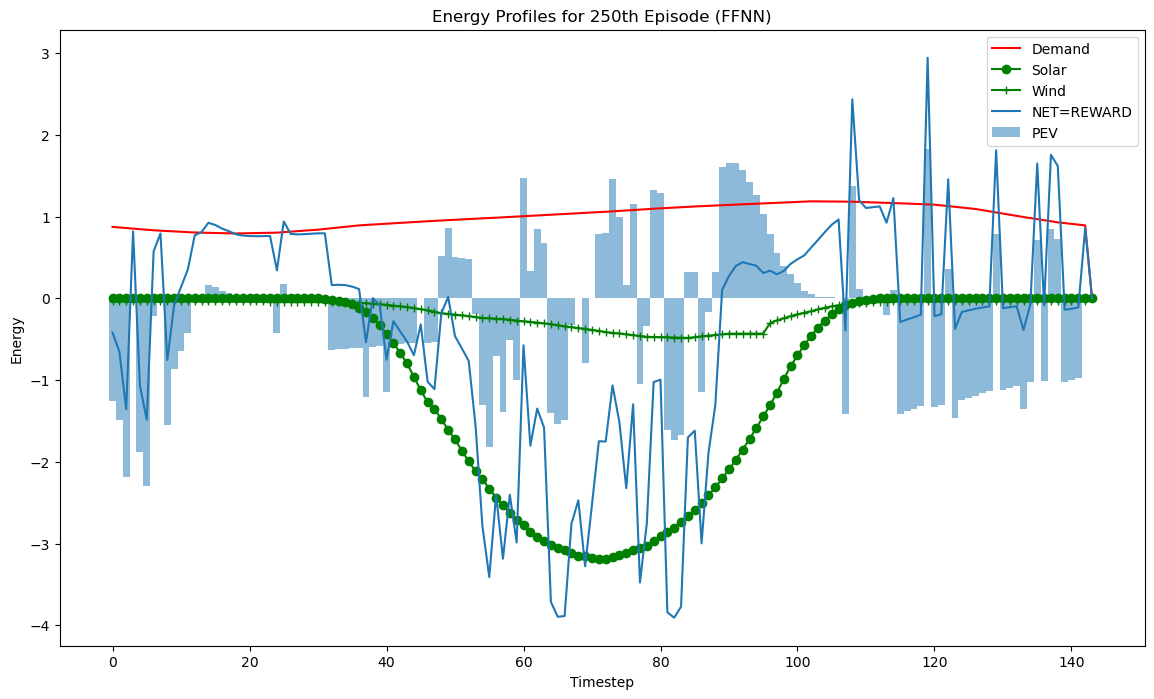

In [5]:
plt.figure(figsize=(14, 8))
plt.plot(demand_profile, label='Demand', color="red")
plt.plot(-1*solar_profile, label='Solar', color='green', marker='o')
plt.plot(-1*wind_profile, label='Wind', color='green', marker='+')

plt.plot(demand_profile+PEV_profile -solar_profile- wind_profile, label='NET=REWARD')

# Plot the PEV_profile as a bar graph
timesteps = np.arange(len(PEV_profile))  
plt.bar(timesteps, PEV_profile, width=1.0, label='PEV', alpha=0.5)  



plt.legend()
plt.title('Energy Profiles for 250th Episode (FFNN)')
plt.xlabel('Timestep')
plt.ylabel('Energy')
#plt.savefig('250_episodes_FFNN.png')
plt.show()